In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import re
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from nltk.corpus import reuters
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
print(reuters.fileids())

['test/14826', 'test/14828', 'test/14829', 'test/14832', 'test/14833', 'test/14839', 'test/14840', 'test/14841', 'test/14842', 'test/14843', 'test/14844', 'test/14849', 'test/14852', 'test/14854', 'test/14858', 'test/14859', 'test/14860', 'test/14861', 'test/14862', 'test/14863', 'test/14865', 'test/14867', 'test/14872', 'test/14873', 'test/14875', 'test/14876', 'test/14877', 'test/14881', 'test/14882', 'test/14885', 'test/14886', 'test/14888', 'test/14890', 'test/14891', 'test/14892', 'test/14899', 'test/14900', 'test/14903', 'test/14904', 'test/14907', 'test/14909', 'test/14911', 'test/14912', 'test/14913', 'test/14918', 'test/14919', 'test/14921', 'test/14922', 'test/14923', 'test/14926', 'test/14928', 'test/14930', 'test/14931', 'test/14932', 'test/14933', 'test/14934', 'test/14941', 'test/14943', 'test/14949', 'test/14951', 'test/14954', 'test/14957', 'test/14958', 'test/14959', 'test/14960', 'test/14962', 'test/14963', 'test/14964', 'test/14965', 'test/14967', 'test/14968', 'test

In [ ]:
for id in reuters.fileids():
  first_text = reuters.raw(id)
  categories = reuters.categories(id)
  break

In [ ]:
print(first_text)

ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exporting
  nations that the row could inflict far-reaching economic
  damage, businessmen and officials said.
      They told Reuter correspondents in Asian capitals a U.S.
  Move against Japan might boost protectionist sentiment in the
  U.S. And lead to curbs on American imports of their products.
      But some exporters said that while the conflict would hurt
  them in the long-run, in the short-term Tokyo's loss might be
  their gain.
      The U.S. Has said it will impose 300 mln dlrs of tariffs on
  imports of Japanese electronics goods on April 17, in
  retaliation for Japan's alleged failure to stick to a pact not
  to sell semiconductors on world markets at below cost.
      Unofficial Japanese estimates put the impact of the tariffs
  at 10 billion dlrs and spokesmen for major electronics firms
  said they would virtually halt exports

In [ ]:
print(categories)

['trade']


In [ ]:
# Loading the complete dataset
documents = reuters.fileids()
data = []
labels = []

for doc_id in documents:
    text = reuters.raw(doc_id)
    category = reuters.categories(doc_id)[0]  # Use the first category as the label
    data.append(text)
    labels.append(category)

print(data[0])
print(labels[0])

ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exporting
  nations that the row could inflict far-reaching economic
  damage, businessmen and officials said.
      They told Reuter correspondents in Asian capitals a U.S.
  Move against Japan might boost protectionist sentiment in the
  U.S. And lead to curbs on American imports of their products.
      But some exporters said that while the conflict would hurt
  them in the long-run, in the short-term Tokyo's loss might be
  their gain.
      The U.S. Has said it will impose 300 mln dlrs of tariffs on
  imports of Japanese electronics goods on April 17, in
  retaliation for Japan's alleged failure to stick to a pact not
  to sell semiconductors on world markets at below cost.
      Unofficial Japanese estimates put the impact of the tariffs
  at 10 billion dlrs and spokesmen for major electronics firms
  said they would virtually halt exports

In [ ]:
# Preprocessing dataset
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return ' '.join(text.split())

data = [clean_text(text) for text in data]

In [ ]:
print(data[0])

asian exporters fear damage from u s japan rift mounting trade friction between the u s and japan has raised fears among many of asia s exporting nations that the row could inflict far reaching economic damage businessmen and officials said they told reuter correspondents in asian capitals a u s move against japan might boost protectionist sentiment in the u s and lead to curbs on american imports of their products but some exporters said that while the conflict would hurt them in the long run in the short term tokyo s loss might be their gain the u s has said it will impose mln dlrs of tariffs on imports of japanese electronics goods on april in retaliation for japan s alleged failure to stick to a pact not to sell semiconductors on world markets at below cost unofficial japanese estimates put the impact of the tariffs at billion dlrs and spokesmen for major electronics firms said they would virtually halt exports of products hit by the new taxes we wouldn t be able to do business sai

In [ ]:
# Encoding the labels
label_map = {label: i for i, label in enumerate(set(labels))}

# Reversing the key-value pairs in the label_map dictionary
new_label_map = {v: k for k, v in label_map.items()}

In [ ]:
print(label_map)

{'money-supply': 0, 'coffee': 1, 'tin': 2, 'rape-oil': 3, 'cpu': 4, 'oilseed': 5, 'strategic-metal': 6, 'copper': 7, 'platinum': 8, 'fuel': 9, 'palm-oil': 10, 'copra-cake': 11, 'nickel': 12, 'lei': 13, 'instal-debt': 14, 'trade': 15, 'corn': 16, 'l-cattle': 17, 'cpi': 18, 'sun-oil': 19, 'nzdlr': 20, 'meal-feed': 21, 'bop': 22, 'hog': 23, 'rice': 24, 'yen': 25, 'jet': 26, 'interest': 27, 'wpi': 28, 'pet-chem': 29, 'barley': 30, 'alum': 31, 'palladium': 32, 'groundnut-oil': 33, 'rand': 34, 'grain': 35, 'tea': 36, 'naphtha': 37, 'income': 38, 'soy-oil': 39, 'gas': 40, 'gold': 41, 'dmk': 42, 'iron-steel': 43, 'carcass': 44, 'orange': 45, 'ship': 46, 'cocoa': 47, 'silver': 48, 'reserves': 49, 'crude': 50, 'dfl': 51, 'nat-gas': 52, 'earn': 53, 'groundnut': 54, 'zinc': 55, 'coconut': 56, 'potato': 57, 'housing': 58, 'castor-oil': 59, 'rubber': 60, 'veg-oil': 61, 'cotton-oil': 62, 'ipi': 63, 'retail': 64, 'lead': 65, 'coconut-oil': 66, 'lumber': 67, 'cotton': 68, 'jobs': 69, 'soybean': 70, 'dl

In [ ]:
print(new_label_map)

{0: 'money-supply', 1: 'coffee', 2: 'tin', 3: 'rape-oil', 4: 'cpu', 5: 'oilseed', 6: 'strategic-metal', 7: 'copper', 8: 'platinum', 9: 'fuel', 10: 'palm-oil', 11: 'copra-cake', 12: 'nickel', 13: 'lei', 14: 'instal-debt', 15: 'trade', 16: 'corn', 17: 'l-cattle', 18: 'cpi', 19: 'sun-oil', 20: 'nzdlr', 21: 'meal-feed', 22: 'bop', 23: 'hog', 24: 'rice', 25: 'yen', 26: 'jet', 27: 'interest', 28: 'wpi', 29: 'pet-chem', 30: 'barley', 31: 'alum', 32: 'palladium', 33: 'groundnut-oil', 34: 'rand', 35: 'grain', 36: 'tea', 37: 'naphtha', 38: 'income', 39: 'soy-oil', 40: 'gas', 41: 'gold', 42: 'dmk', 43: 'iron-steel', 44: 'carcass', 45: 'orange', 46: 'ship', 47: 'cocoa', 48: 'silver', 49: 'reserves', 50: 'crude', 51: 'dfl', 52: 'nat-gas', 53: 'earn', 54: 'groundnut', 55: 'zinc', 56: 'coconut', 57: 'potato', 58: 'housing', 59: 'castor-oil', 60: 'rubber', 61: 'veg-oil', 62: 'cotton-oil', 63: 'ipi', 64: 'retail', 65: 'lead', 66: 'coconut-oil', 67: 'lumber', 68: 'cotton', 69: 'jobs', 70: 'soybean', 71:

In [ ]:
# Encoding - converting labels into numbers
labels = [label_map[label] for label in labels]

In [ ]:
print(labels)

[15, 35, 50, 16, 10, 46, 1, 35, 41, 75, 2, 27, 75, 63, 44, 53, 53, 27, 22, 40, 75, 69, 53, 53, 53, 53, 2, 15, 55, 77, 77, 75, 27, 18, 5, 53, 75, 53, 15, 75, 75, 53, 15, 71, 18, 27, 75, 77, 77, 53, 12, 53, 71, 75, 53, 53, 75, 75, 75, 54, 53, 46, 53, 46, 53, 53, 53, 27, 53, 53, 53, 53, 53, 53, 69, 53, 75, 53, 75, 53, 53, 53, 77, 78, 77, 53, 53, 53, 53, 75, 53, 75, 53, 53, 53, 53, 77, 53, 77, 53, 53, 75, 53, 53, 53, 53, 75, 53, 16, 75, 73, 16, 69, 53, 78, 27, 75, 53, 53, 53, 75, 75, 53, 75, 53, 53, 75, 53, 53, 53, 53, 53, 53, 53, 75, 27, 53, 53, 47, 27, 35, 53, 53, 16, 53, 53, 53, 75, 2, 53, 75, 53, 53, 75, 75, 53, 75, 5, 53, 35, 53, 75, 53, 53, 53, 75, 75, 53, 53, 15, 75, 53, 75, 53, 15, 53, 53, 47, 53, 53, 53, 53, 53, 53, 53, 53, 1, 50, 75, 53, 24, 53, 53, 75, 53, 71, 53, 75, 2, 68, 53, 53, 15, 53, 53, 50, 53, 78, 72, 50, 75, 53, 0, 53, 50, 0, 53, 53, 78, 44, 75, 53, 53, 43, 53, 7, 53, 53, 35, 35, 53, 75, 53, 53, 75, 53, 16, 17, 53, 75, 53, 53, 53, 53, 75, 35, 75, 53, 75, 53, 27, 75, 53

In [ ]:
# Splitting the data into training(80 percent) and testing(20 percent) datasets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
print(X_train[4])

ec commission given plan to save steel industry european community steelmakers presented the executive commission with a controversial plan for the future of the industry which diplomats say it may be forced reluctantly to accept under the plan steel output would remain subject to restrictive quotas and imports would be firmly controlled for years to come while steel firms undertook a massive slimming down operation to adjust capacity to lower demand industry commissioner karl heinz narjes has proposed the ending of the quota system by december he has proposed a return to the free market which under ec law is supposed to exist except in times of manifest crisis but diplomats said some ministers who meet to discuss this idea on march will argue that steel firms are in crisis in their countries with orders falling as customers switch to alternative products and accounts firmly in the red ministers from the ec s major steel producing countries are likely to shy away from narjes proposals 

In [ ]:
print(y_train[4])

43


In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenizing
def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_text = tokenizer(text, padding='max_length', truncation=True, max_length=512)
        input_ids.append(encoded_text['input_ids'])
        attention_masks.append(encoded_text['attention_mask'])

    return CustomDataset({
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels)

In [ ]:
train_data = tokenize_data(X_train, y_train)
test_data = tokenize_data(X_test, y_test)

In [ ]:
# Finetuning the model
# The number of labels is matched to our dataset
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Training the model on our dataset
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,2.752100,1.993841
200,1.760500,1.480211
300,1.349200,1.224706
400,1.102700,1.031424
500,1.091600,0.926611
600,0.881800,0.820091
700,0.792600,0.753361
800,0.723800,0.693032
900,0.756800,0.627867
1000,0.658200,0.608112


Step,Training Loss,Validation Loss
100,2.752100,1.993841
200,1.760500,1.480211
300,1.349200,1.224706
400,1.102700,1.031424
500,1.091600,0.926611
600,0.881800,0.820091
700,0.792600,0.753361
800,0.723800,0.693032
900,0.756800,0.627867
1000,0.658200,0.608112


TrainOutput(global_step=4316, training_loss=0.521607182830213, metrics={'train_runtime': 6453.604, 'train_samples_per_second': 5.349, 'train_steps_per_second': 0.669, 'total_flos': 9088872899665920.0, 'train_loss': 0.521607182830213, 'epoch': 4.0})

In [ ]:
# Evaluating on test dataset
predictions = trainer.predict(test_data)
y_pred = np.argmax(predictions.predictions, axis=1)

In [ ]:
# Calculating Accuracy, Precision, Recall and F1 score for our model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.9319
Precision: 0.9289
Recall: 0.9319
F1-score: 0.9271


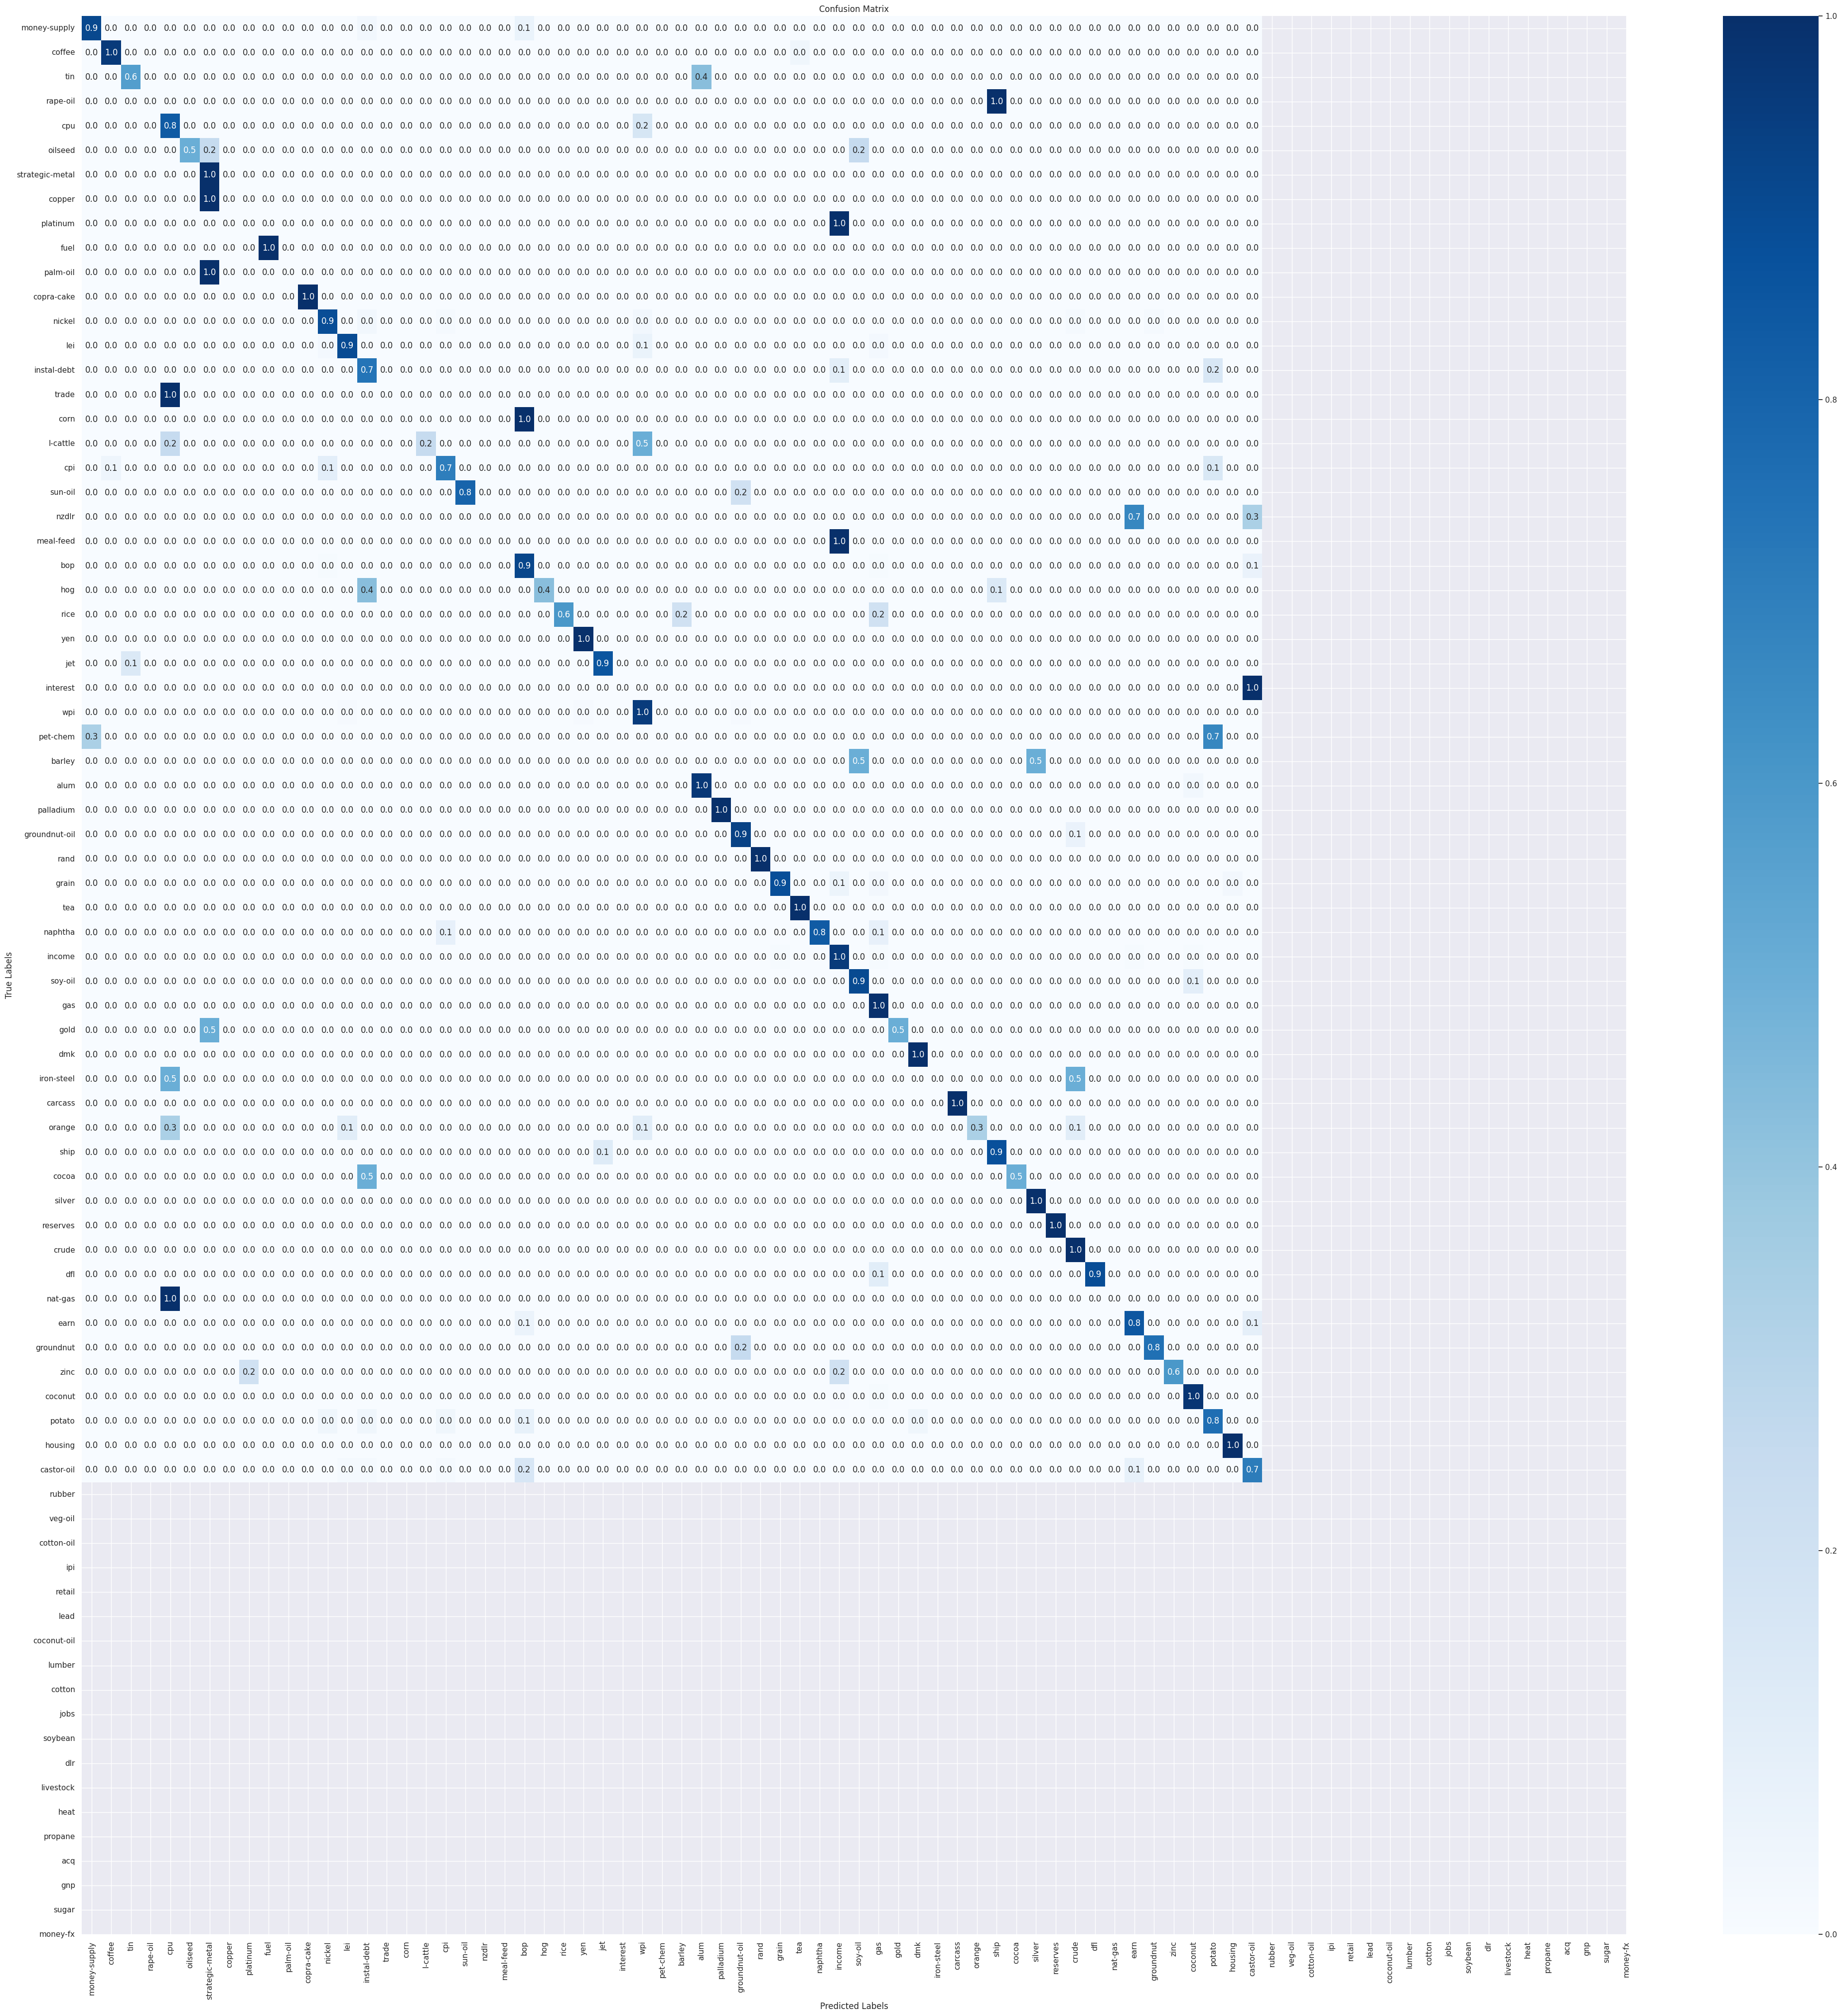

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to show percentages
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
plt.figure(figsize=(50, 50))
sns.set(font_scale=1.0)
ax = sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())

# Set labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Find the union of unique labels in y_test and y_pred
unique_labels = np.union1d(np.unique(y_test), np.unique(y_pred))

# Create a new label map for the unique labels
new_label_map = {str(label): label_map.get(label, label) for label in unique_labels}

# Get the target names for the unique labels
target_names = [str(label) for label in new_label_map.values()]

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)


              precision    recall  f1-score   support

           0       0.97      0.91      0.94        32
           1       0.96      0.96      0.96        25
           2       0.80      0.57      0.67         7
           4       0.00      0.00      0.00         1
           5       0.42      0.83      0.56         6
           6       1.00      0.50      0.67         4
           7       0.64      1.00      0.78         9
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         7
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          15       0.90      0.89      0.90        63
          16       0.93      0.90      0.91        48
          18       0.58      0.74      0.65        19
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          21       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Save the model
model.save_pretrained("./saved_model")

# Save the tokenizer
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [ ]:
!zip -r saved_model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/tokenizer_config.json (deflated 45%)
  adding: saved_model/vocab.txt (deflated 53%)
  adding: saved_model/config.json (deflated 72%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/pytorch_model.bin (deflated 7%)
